# Atlanta Police Department
![APD Logo](https://atlantapd.galls.com/photos/partners/atlantapd/logo.jpg)


The Atlanta Police Department provides Part 1 crime data at http://www.atlantapd.org/i-want-to/crime-data-downloads

A recent copy of the data file is stored in the cluster. <span style="color: red; font-weight: bold;">Please, do not copy this data file into your home directory!</span>

# Introduction


- This notebooks leads into an exploration of public crime data provided by the Atlanta Police Department.
- The original data set and supplemental information can be found at http://www.atlantapd.org/i-want-to/crime-data-downloads

## Focus on Fundemantal Pandas Operations


### Pandas:
* merge (left_on, right_on and how)
* concat
* append
* (i)loc -- columns and rows
* (i)at  -- elements
* groupby

### Apply:
* for loop
* a bit **count-intuitive**
    * axis = 1 -- **applying for loops on rows**
    * axis = 0 -- **applying for loops on columns**

### Lambda:
* operations for each for loop

In [9]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
# load data set
df = pd.read_csv('COBRA-YTD-multiyear.csv.gz',low_memory=False)
print("Shape of table: ", df.shape)

Shape of table:  (285733, 23)


In [11]:
df.head()

,MI_PRINX,offense_id,rpt_date,occur_date,occur_time,poss_date,poss_time,beat,apt_office_prefix,apt_office_num,...,dispo_code,MaxOfnum_victims,Shift,Avg Day,loc_type,UC2 Literal,neighborhood,npu,x,y
0,1160569,90360664,02/05/2009,02/03/2009,13:50:00,02/03/2009,15:00:00,305.0,NaN,NaN,...,NaN,1.0,Day,Tue,35.0,LARCENY-NON VEHICLE,South Atlanta,Y,-84.38654,33.72024
1,1160570,90370891,02/06/2009,02/06/2009,08:50:00,02/06/2009,10:45:00,502.0,NaN,NaN,...,NaN,1.0,Day,Fri,18.0,LARCENY-FROM VEHICLE,Ansley Park,E,-84.37276,33.79685
2,1160572,91681984,06/17/2009,06/17/2009,14:00:00,06/17/2009,15:00:00,604.0,NaN,816,...,NaN,1.0,Day,Wed,NaN,LARCENY-NON VEHICLE,Sweet Auburn,M,-84.37521,33.75540
3,1160575,82040835,02/27/2009,07/21/2008,18:00:00,07/21/2008,18:00:00,104.0,NaN,NaN,...,50,1.0,Eve,Mon,20.0,BURGLARY-RESIDENCE,Mozley Park,K,-84.44342,33.75265
4,1160576,82922120,01/14/2009,10/19/2008,18:30:00,10/19/2008,19:45:00,210.0,NaN,NaN,...,NaN,1.0,Eve,Sun,18.0,AUTO THEFT,Lenox,B,-84.36212,33.84676


## Review: Creating a data key

Let's look at the structure of this table. We're actually creating some text output that can be used to create a data dictionary.

In [12]:
dataDict = pd.DataFrame({'DataType': df.dtypes.values, 'Description': ''}, index=df.columns.values)

We need to enter the descriptions for each entry in our dictionary manually...

In [13]:
dataDict.loc['MI_PRINX'].Description = '' # type: int64
dataDict.loc['offense_id'].Description = 'Unique ID in the format YYDDDNNNN with the year YY, the day of the year DDD and a counter NNNN' # type: int64
dataDict.loc['rpt_date'].Description = 'Date the crime was reported' # type: object
dataDict.loc['occur_date'].Description = 'Estimated date when the crime occured' # type: object
dataDict.loc['occur_time'].Description = 'Estimated time when the crime occured' # type: object
dataDict.loc['poss_date'].Description = '' # type: object
dataDict.loc['poss_time'].Description = '' # type: object
dataDict.loc['beat'].Description = '' # type: int64
dataDict.loc['apt_office_prefix'].Description = '' # type: object
dataDict.loc['apt_office_num'].Description = '' # type: object
dataDict.loc['location'].Description = '' # type: object
dataDict.loc['MinOfucr'].Description = '' # type: int64
dataDict.loc['MinOfibr_code'].Description = '' # type: object
dataDict.loc['dispo_code'].Description = '' # type: object
dataDict.loc['MaxOfnum_victims'].Description = '' # type: float64
dataDict.loc['Shift'].Description = 'Zones have 8 or 10 hour shifts' # type: object
dataDict.loc['Avg Day'].Description = '' # type: object
dataDict.loc['loc_type'].Description = '' # type: float64
dataDict.loc['UC2 Literal'].Description = '' # type: object
dataDict.loc['neighborhood'].Description = '' # type: object
dataDict.loc['npu'].Description = '' # type: object
dataDict.loc['x'].Description = '' # type: float64
dataDict.loc['y'].Description = '' # type: float64
dataDict.to_csv("COBRA_Data_Dictionary.csv")

In [14]:
dataDict

,DataType,Description
MI_PRINX,int64,
offense_id,int64,Unique ID in the format YYDDDNNNN with the yea...
rpt_date,object,Date the crime was reported
occur_date,object,Estimated date when the crime occured
occur_time,object,Estimated time when the crime occured
poss_date,object,
poss_time,object,
beat,float64,
apt_office_prefix,object,
apt_office_num,object,


## Convert Time Columns

Please refer to the following resources for working with time series data in pandas:
- https://pandas.pydata.org/pandas-docs/stable/timeseries.html
- https://pandas.pydata.org/pandas-docs/stable/api.html#id10

In [15]:
# function currying
def fixdatetime(fld):
    def _fix(s):
        date_col = '%s_date' % fld # "rpt_date"
        time_col = '%s_time' % fld # "rpt_time"
        if time_col in s.index:
            return str(s[date_col])+' '+str(s[time_col])
        else:
            return str(s[date_col])+' 00:00:00'
    return _fix

In [16]:
for col in ['rpt', 'occur', 'poss']:
    datser = df.apply(fixdatetime(col), axis=1)
    df['%s_dt'%col] = pd.to_datetime(datser, format="%m/%d/%Y %H:%M:%S", errors='coerce')
      #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

In [17]:
df[["MI_PRINX", "offense_id", "beat", "UC2 Literal", "neighborhood", "rpt_dt", "occur_dt", "poss_dt"]].head()

,MI_PRINX,offense_id,beat,UC2 Literal,neighborhood,rpt_dt,occur_dt,poss_dt
0,1160569,90360664,305.0,LARCENY-NON VEHICLE,South Atlanta,2009-02-05,2009-02-03 13:50:00,2009-02-03 15:00:00
1,1160570,90370891,502.0,LARCENY-FROM VEHICLE,Ansley Park,2009-02-06,2009-02-06 08:50:00,2009-02-06 10:45:00
2,1160572,91681984,604.0,LARCENY-NON VEHICLE,Sweet Auburn,2009-06-17,2009-06-17 14:00:00,2009-06-17 15:00:00
3,1160575,82040835,104.0,BURGLARY-RESIDENCE,Mozley Park,2009-02-27,2008-07-21 18:00:00,2008-07-21 18:00:00
4,1160576,82922120,210.0,AUTO THEFT,Lenox,2009-01-14,2008-10-19 18:30:00,2008-10-19 19:45:00


What's the date range of the data?

In [18]:
print (df.occur_dt.min(), '---', df.occur_dt.max())

1916-01-07 12:15:00 --- 2017-09-28 02:07:00


Number of crimes reported each year:

In [30]:
# resample is like "groupby" for time
df.resample('A-DEC', closed='right', on='occur_dt').offense_id.count()


occur_dt
2010-12-31    35781
2011-12-31    35144
2012-12-31    33328
2013-12-31    32226
2014-12-31    31115
2015-12-31    30050
2016-12-31    29079
2017-12-31    18861
Freq: A-DEC, Name: offense_id, dtype: int64

Looks like most of the data is actually from 2009-2017! Let's throw the rest away...

In [24]:
df['Year'] = df.occur_dt.map(lambda d: d.year)
df = df[(df.Year>=2010) & (df.Year<=2017)]
df.shape

(245584, 27)

# Crime Over Time

Has the number of crimes in Atlanta changed over time?

Are some areas more affected by crime than others?

Do different types of crime correlate with each other?

## Number of Crimes Over Time, with Pivot Tables

In [31]:
df[["occur_dt", "UC2 Literal", "offense_id"]].head()

,occur_dt,UC2 Literal,offense_id
39626,2010-02-24 23:29:00,AGG ASSAULT,72692336
39645,2010-01-01 00:15:00,LARCENY-FROM VEHICLE,100010121
39647,2010-01-01 00:30:00,ROBBERY-PEDESTRIAN,100010147
39648,2010-01-01 00:45:00,BURGLARY-RESIDENCE,100010149
39651,2010-01-01 01:25:00,BURGLARY-NONRES,100010236


In [32]:
# Pivoting the table:
# index = column that the new table will be indexed by
# columns = column whose unique values will form the new column names
# values = values used to fill the table 
    # (default = all columns other than those given in index and columns)
df_ct = df.pivot_table(index="occur_dt", columns="UC2 Literal", values="offense_id")

In [33]:
df_ct.head()

UC2 Literal,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,RAPE,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE
occur_dt,,,,,,,,,,,
2010-01-01 00:00:00,NaN,NaN,100511327.0,100740960.0,NaN,NaN,100011728.0,NaN,NaN,NaN,NaN
2010-01-01 00:01:00,NaN,NaN,NaN,100120887.0,NaN,101710613.0,101581009.0,NaN,NaN,NaN,NaN
2010-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,100010121.0,NaN,NaN,NaN,NaN,NaN
2010-01-01 00:30:00,NaN,NaN,NaN,100011029.0,NaN,100010372.0,100021285.0,NaN,NaN,100010147.0,NaN
2010-01-01 00:45:00,NaN,NaN,NaN,100010149.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This gives us a timeline for different types of crime reported in Atlanta.

By itself, this can be useful, but we are more interested in aggregate statistics. Let's get the number of crimes by month...

In [34]:
df_ct = df_ct.resample("1M", closed="right").count()

In [35]:
df_ct.head()

UC2 Literal,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,RAPE,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE
occur_dt,,,,,,,,,,,
2010-01-31,177,360,104,440,3,544,547,6,13,137,23
2010-02-28,155,235,75,342,4,411,480,7,14,84,10
2010-03-31,216,300,106,416,8,574,534,1,14,109,21
2010-04-30,220,379,127,466,8,644,605,10,14,149,19
2010-05-31,230,388,114,486,4,640,653,6,16,133,18


Average number of crimes per month, for each year:

Text(0, 0.5, 'Total Reported Crimes by Month')

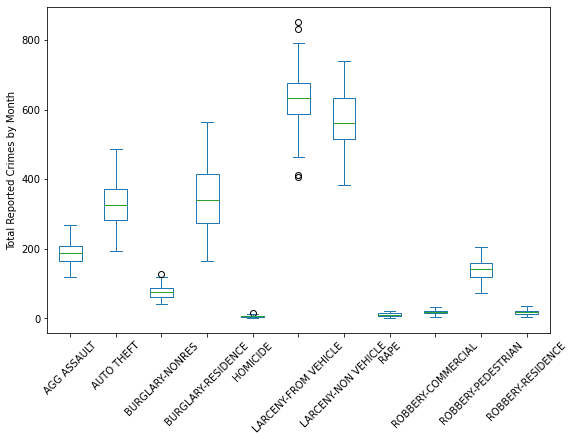

In [40]:
ax = df_ct.plot.box(figsize=(9,6), rot=45)
plt.ylabel("Total Reported Crimes by Month")

Explanation of boxplot:

From the matplotlib documentation (http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.boxplot):

The box extends from the **lower to upper quartile values** of the data, with a line at the **median**. The whiskers extend from the box to show the range of the data. Flier points are those past the end of the whiskers.

**Whiskers:** IQR is the interquartile range (Q3-Q1). The upper whisker will extend to last datum less than Q3 + whis*IQR (where the default value for whis is 1.5). Similarly, the lower whisker will extend to the first datum greater than Q1 - whis*IQR. Beyond the whiskers, data are considered outliers and are plotted as individual points. 

In [19]:
## In-class exercise:
# Make a boxplot of the number of reported crimes, aggregating by week. 

Text(0, 0.5, 'Total Reported Crimes by Week')

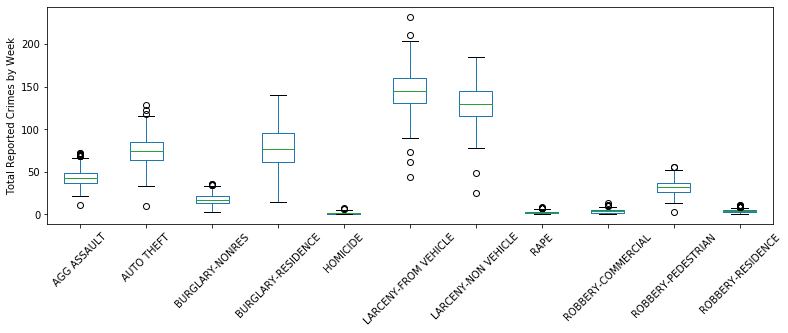

In [20]:
df_wk = df.pivot_table(index="occur_dt", columns="UC2 Literal", values="offense_id")
df_wk = df_wk.resample("W-SUN", closed='right').count()
df_wk.plot.box(figsize=(13,4), rot=45)
plt.ylabel("Total Reported Crimes by Week")

More on pandas datetime objects:

http://pandas-docs.github.io/pandas-docs-travis/timeseries.html#dateoffset-objects

http://pandas-docs.github.io/pandas-docs-travis/timeseries.html#anchored-offsets

### Crimes over time

Let's take a look at a time series plot of the number of crimes over time...

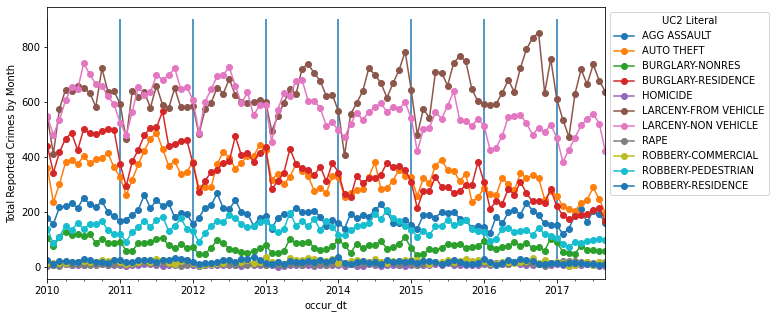

In [41]:
ax = df_ct.plot(figsize=(10,5), style='-o')
ax.get_legend().set_bbox_to_anchor((1, 1))
plt.ylabel("Total Reported Crimes by Month")
ax.vlines(pd.date_range("12/31/2009", "12/31/2017", freq="A-JAN"), 0, 900)

Can you pick out the seasonal variation in number of crimes per year?

Suppose we are not interested in seasonal trends, but want to see if the number of reported crimes is changing year over year. We could simply add the number of crimes together to get number of crimes reported each year.

In [22]:
ann_cr = df_ct.resample("A-DEC", closed="right").sum()

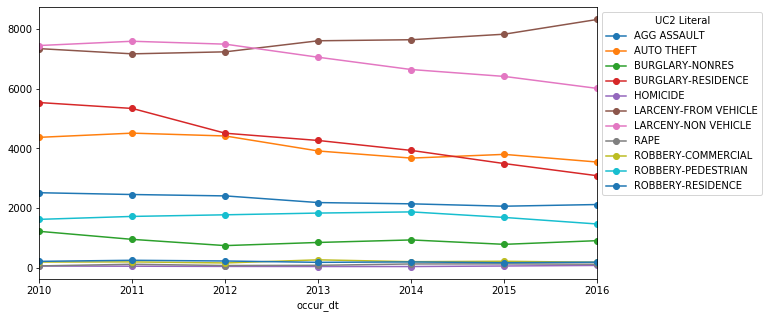

In [23]:
ax = ann_cr[ann_cr.index<"01/01/2017"].plot(figsize=(10,5), style='-o')
ax.get_legend().set_bbox_to_anchor((1, 1))

## Correlation In Number of Crimes Over Time

You can use the "corr" method in Pandas to find the correlation between columns of a dataframe. 

In [43]:
crime_corr = df_ct.corr()

In [44]:
crime_corr

UC2 Literal,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,RAPE,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE
UC2 Literal,,,,,,,,,,,
AGG ASSAULT,1.000000,0.537531,0.413021,0.523782,0.131431,0.301379,0.718308,-0.169582,0.113623,0.425422,0.210735
AUTO THEFT,0.537531,1.000000,0.416275,0.777676,0.120724,0.186650,0.730546,-0.291814,0.343916,0.605102,0.506369
BURGLARY-NONRES,0.413021,0.416275,1.000000,0.545178,0.167527,0.260829,0.453262,-0.033910,0.216145,0.322221,0.307990
BURGLARY-RESIDENCE,0.523782,0.777676,0.545178,1.000000,0.066394,-0.044012,0.777592,-0.366712,0.320129,0.568651,0.533289
HOMICIDE,0.131431,0.120724,0.167527,0.066394,1.000000,0.216263,0.105361,0.020965,0.178784,0.171028,0.130341
LARCENY-FROM VEHICLE,0.301379,0.186650,0.260829,-0.044012,0.216263,1.000000,0.234329,0.196354,0.322428,0.341674,0.030892
LARCENY-NON VEHICLE,0.718308,0.730546,0.453262,0.777592,0.105361,0.234329,1.000000,-0.278228,0.262001,0.635482,0.433759
RAPE,-0.169582,-0.291814,-0.033910,-0.366712,0.020965,0.196354,-0.278228,1.000000,-0.188888,-0.180836,-0.161259
ROBBERY-COMMERCIAL,0.113623,0.343916,0.216145,0.320129,0.178784,0.322428,0.262001,-0.188888,1.000000,0.519302,0.188007


Visualizing the correlation...

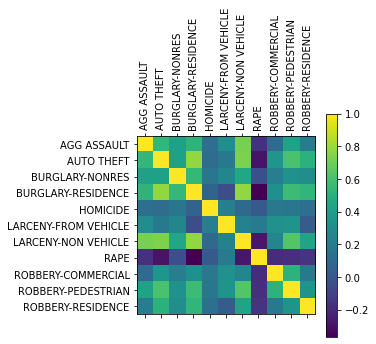

In [47]:
plt.matshow(crime_corr);
plt.yticks(range(len(crime_corr.columns)), crime_corr.columns);
plt.xticks(range(len(crime_corr.columns)), crime_corr.columns, rotation=90);
plt.colorbar();

# Crimes By Place

## Beats and Zones
The City of Atlanta is divided into 6 zones, each with 12 to 14 beats. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Atlanta_Police_Zones_-_Feb_2013.jpg/588px-Atlanta_Police_Zones_-_Feb_2013.jpg)

In [48]:
df['Zone'] = df['beat']//100
df['Year'] = df.occur_dt.apply(lambda x: x.year)

In [49]:
df_cp = df.pivot_table(index="Zone", 
                       columns="UC2 Literal", 
                       values="offense_id", 
                       aggfunc=lambda x: np.count_nonzero(~np.isnan(x)))

In [50]:
df_cp

UC2 Literal,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,RAPE,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE
Zone,,,,,,,,,,,
0.0,3.0,15.0,2.0,NaN,NaN,40.0,193.0,NaN,NaN,1.0,NaN
1.0,4818.0,5986.0,1045.0,8432.0,172.0,6779.0,7552.0,211.0,175.0,2658.0,397.0
2.0,1084.0,3982.0,1530.0,4369.0,21.0,16127.0,13945.0,134.0,334.0,1139.0,163.0
3.0,4700.0,7506.0,1401.0,8511.0,152.0,7522.0,7359.0,201.0,281.0,2727.0,381.0
4.0,3823.0,7413.0,1254.0,9264.0,117.0,8241.0,9488.0,174.0,349.0,2524.0,378.0
5.0,1651.0,3750.0,893.0,1168.0,44.0,18825.0,11016.0,159.0,216.0,1985.0,111.0
6.0,1686.0,5448.0,1090.0,5121.0,64.0,13859.0,9102.0,112.0,291.0,2022.0,212.0
7.0,27.0,96.0,8.0,NaN,NaN,265.0,1278.0,2.0,NaN,6.0,NaN
9.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [51]:
df_cp = df.pivot_table(index=["Year","Zone"], 
                       columns="UC2 Literal", 
                       values="offense_id", 
                       aggfunc=lambda x: np.count_nonzero(~np.isnan(x)))

In [52]:
df_cp

UC2 Literal  AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  BURGLARY-RESIDENCE  \
Year Zone                                                                   
2010 0.0             3.0        15.0              2.0                 NaN   
     1.0           777.0       771.0            204.0              1618.0   
     2.0           131.0       611.0            233.0               746.0   
     3.0           662.0      1077.0            234.0              1627.0   
     4.0           524.0      1129.0            240.0              1695.0   
     5.0           222.0       589.0            162.0               154.0   
     6.0           271.0       812.0            198.0               873.0   
     7.0             NaN         4.0              NaN                 NaN   
2011 1.0           667.0       973.0            154.0              1457.0   
     2.0           145.0       545.0            175.0               643.0   
     3.0           681.0      1105.0            229.0              1645.0   
     4.0           547.0      1090.0            210.0              1680.0   
     5.0           225.0       647.0            112.0               166.0   
     6.0           246.0       845.0            114.0               818.0   
     7.0             4.0        30.0              NaN                 NaN   
2012 1.0           656.0      1037.0            116.0              1284.0   
     2.0           158.0       487.0            168.0               699.0   
     3.0           622.0      1171.0            157.0              1284.0   
     4.0           543.0      1010.0            117.0              1237.0   
     5.0           209.0       475.0             96.0               172.0   
     6.0           266.0       887.0            119.0               578.0   
     7.0             4.0        30.0              2.0                 NaN   
2013 1.0           579.0       739.0            152.0              1081.0   
     2.0           143.0       407.0            158.0               538.0   
     3.0           560.0      1068.0            179.0              1050.0   
     4.0           512.0       935.0            141.0              1250.0   
     5.0           213.0       447.0            103.0               138.0   
     6.0           222.0       844.0            151.0               835.0   
     7.0             3.0         8.0              1.0                 NaN   
     9.0             NaN         NaN              NaN                 NaN   
2014 1.0           565.0       703.0            128.0               937.0   
     2.0           139.0       423.0            224.0               497.0   
     3.0           622.0       841.0            206.0              1080.0   
     4.0           453.0       957.0            148.0              1145.0   
     5.0           213.0       480.0            121.0               140.0   
     6.0           190.0       717.0            139.0               644.0   
     7.0             1.0         9.0              2.0                 NaN   
2015 1.0           523.0       705.0            110.0               855.0   
     2.0           138.0       472.0            208.0               507.0   
     3.0           586.0       971.0            151.0               846.0   
     4.0           456.0       945.0            125.0               939.0   
     5.0           226.0       469.0             90.0               189.0   
     6.0           177.0       650.0            128.0               583.0   
     7.0             5.0         6.0              NaN                 NaN   
2016 1.0           621.0       707.0            109.0               762.0   
     2.0           129.0       615.0            245.0               502.0   
     3.0           599.0       778.0            142.0               628.0   
     4.0           440.0       903.0            165.0               858.0   
     5.0           189.0       364.0            146.0               140.0   
     6.0           181.0       460.0            149.0               508.0

In [53]:
df_cp = df_cp[np.logical_and([x >= 1 for x in list(zip(*df_cp.index.values))[1]], 
                             [x <= 6 for x in list(zip(*df_cp.index.values))[1]])].fillna(0)
df_cp.head(20)

UC2 Literal  AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  BURGLARY-RESIDENCE  \
Year Zone                                                                   
2010 1.0           777.0       771.0            204.0              1618.0   
     2.0           131.0       611.0            233.0               746.0   
     3.0           662.0      1077.0            234.0              1627.0   
     4.0           524.0      1129.0            240.0              1695.0   
     5.0           222.0       589.0            162.0               154.0   
     6.0           271.0       812.0            198.0               873.0   
2011 1.0           667.0       973.0            154.0              1457.0   
     2.0           145.0       545.0            175.0               643.0   
     3.0           681.0      1105.0            229.0              1645.0   
     4.0           547.0      1090.0            210.0              1680.0   
     5.0           225.0       647.0            112.0               166.0   
     6.0           246.0       845.0            114.0               818.0   
2012 1.0           656.0      1037.0            116.0              1284.0   
     2.0           158.0       487.0            168.0               699.0   
     3.0           622.0      1171.0            157.0              1284.0   
     4.0           543.0      1010.0            117.0              1237.0   
     5.0           209.0       475.0             96.0               172.0   
     6.0           266.0       887.0            119.0               578.0   
2013 1.0           579.0       739.0            152.0              1081.0   
     2.0           143.0       407.0            158.0               538.0   

UC2 Literal  HOMICIDE  LARCENY-FROM VEHICLE  LARCENY-NON VEHICLE  RAPE  \
Year Zone                                                                
2010 1.0         24.0                 855.0               1110.0   6.0   
     2.0          5.0                2152.0               1902.0  16.0   
     3.0         21.0                 854.0               1213.0  20.0   
     4.0         15.0                 971.0               1476.0  19.0   
     5.0          5.0                2632.0               1543.0   8.0   
     6.0         10.0                1714.0               1263.0  11.0   
2011 1.0         23.0                 861.0               1163.0  31.0   
     2.0          1.0                1662.0               1859.0  16.0   
     3.0         18.0                 928.0               1293.0  35.0   
     4.0         15.0                 969.0               1381.0  26.0   
     5.0          6.0                2526.0               1593.0  11.0   
     6.0         12.0                1642.0               1429.0  16.0   
2012 1.0         20.0                 886.0               1013.0  16.0   
     2.0          0.0                2123.0               1817.0   8.0   
     3.0         16.0                 762.0               1050.0  16.0   
     4.0         17.0                 771.0               1540.0  24.0   
     5.0          4.0                2274.0               1545.0   9.0   
     6.0          8.0                1938.0               1356.0  20.0   
2013 1.0         20.0                 665.0               1043.0  19.0   
     2.0          3.0                2178.0               1693.0  15.0   

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE  
Year Zone                                                               
2010 1.0                   23.0               346.0               53.0  
     2.0                   44.0               116.0               30.0  
     3.0                   39.0               333.0               49.0  
     4.0                   33.0               304.0               45.0  
     5.0                   21.0               276.0               18.0  
     6.0                   48.0               284.0               38.0  
2011 1.0                   22.0               360.0               67.0  
     2.0           

In [54]:
#list(zip(*df_cp.index.values))[0]

In [34]:
# A MUCH PRETTIER way to do the same thing:
df_cp = df_cp.loc[(slice(None), slice(1,6)),:].fillna(0)
df_cp.head(20)

UC2 Literal  AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  BURGLARY-RESIDENCE  \
Year Zone                                                                   
2010 1.0           777.0       771.0            204.0              1618.0   
     2.0           131.0       611.0            233.0               746.0   
     3.0           662.0      1077.0            234.0              1627.0   
     4.0           524.0      1129.0            240.0              1695.0   
     5.0           222.0       589.0            162.0               154.0   
     6.0           271.0       812.0            198.0               873.0   
2011 1.0           667.0       973.0            154.0              1457.0   
     2.0           145.0       545.0            175.0               643.0   
     3.0           681.0      1105.0            229.0              1645.0   
     4.0           547.0      1090.0            210.0              1680.0   
     5.0           225.0       647.0            112.0               166.0   
     6.0           246.0       845.0            114.0               818.0   
2012 1.0           656.0      1037.0            116.0              1284.0   
     2.0           158.0       487.0            168.0               699.0   
     3.0           622.0      1171.0            157.0              1284.0   
     4.0           543.0      1010.0            117.0              1237.0   
     5.0           209.0       475.0             96.0               172.0   
     6.0           266.0       887.0            119.0               578.0   
2013 1.0           579.0       739.0            152.0              1081.0   
     2.0           143.0       407.0            158.0               538.0   

UC2 Literal  HOMICIDE  LARCENY-FROM VEHICLE  LARCENY-NON VEHICLE  RAPE  \
Year Zone                                                                
2010 1.0         24.0                 855.0               1110.0   6.0   
     2.0          5.0                2152.0               1902.0  16.0   
     3.0         21.0                 854.0               1213.0  20.0   
     4.0         15.0                 971.0               1476.0  19.0   
     5.0          5.0                2632.0               1543.0   8.0   
     6.0         10.0                1714.0               1263.0  11.0   
2011 1.0         23.0                 861.0               1163.0  31.0   
     2.0          1.0                1662.0               1859.0  16.0   
     3.0         18.0                 928.0               1293.0  35.0   
     4.0         15.0                 969.0               1381.0  26.0   
     5.0          6.0                2526.0               1593.0  11.0   
     6.0         12.0                1642.0               1429.0  16.0   
2012 1.0         20.0                 886.0               1013.0  16.0   
     2.0          0.0                2123.0               1817.0   8.0   
     3.0         16.0                 762.0               1050.0  16.0   
     4.0         17.0                 771.0               1540.0  24.0   
     5.0          4.0                2274.0               1545.0   9.0   
     6.0          8.0                1938.0               1356.0  20.0   
2013 1.0         20.0                 665.0               1043.0  19.0   
     2.0          3.0                2178.0               1693.0  15.0   

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE  
Year Zone                                                               
2010 1.0                   23.0               346.0               53.0  
     2.0                   44.0               116.0               30.0  
     3.0                   39.0               333.0               49.0  
     4.0                   33.0               304.0               45.0  
     5.0                   21.0               276.0               18.0  
     6.0                   48.0               284.0               38.0  
2011 1.0                   22.0               360.0               67.0  
     2.0           

In [55]:
## slicing on a multi-index
#  get data for 2009-2010, for zones 1-3 
df_cp.loc[(slice(2009,2010), slice(1,5,2)),:]

UC2 Literal  AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  BURGLARY-RESIDENCE  \
Year Zone                                                                   
2010 1.0           777.0       771.0            204.0              1618.0   
     3.0           662.0      1077.0            234.0              1627.0   
     5.0           222.0       589.0            162.0               154.0   

UC2 Literal  HOMICIDE  LARCENY-FROM VEHICLE  LARCENY-NON VEHICLE  RAPE  \
Year Zone                                                                
2010 1.0         24.0                 855.0               1110.0   6.0   
     3.0         21.0                 854.0               1213.0  20.0   
     5.0          5.0                2632.0               1543.0   8.0   

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE  
Year Zone                                                               
2010 1.0                   23.0               346.0               53.0  
     3.0                   39.0               333.0               49.0  
     5.0                   21.0               276.0               18.0

In [36]:
## In-class exercise:
# Show all robbery data for 2011, 2013, and 2015, for zones 4-6 

In [37]:
df_cp.loc[(slice(2011,2015,2), slice(4,6)), "ROBBERY-COMMERCIAL":"ROBBERY-RESIDENCE"]

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE
Year Zone                                                             
2011 4.0                   44.0               325.0               53.0
     5.0                   20.0               250.0               22.0
     6.0                   39.0               300.0               31.0
2013 4.0                   69.0               408.0               53.0
     5.0                   46.0               256.0               13.0
     6.0                   44.0               328.0               25.0
2015 4.0                   53.0               329.0               48.0
     5.0                   34.0               283.0               13.0
     6.0                   45.0               240.0               15.0

In [38]:
df_cp.filter(like='ROBBERY').loc[(slice(2011,2015,2), slice(4,6)), :]

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE
Year Zone                                                             
2011 4.0                   44.0               325.0               53.0
     5.0                   20.0               250.0               22.0
     6.0                   39.0               300.0               31.0
2013 4.0                   69.0               408.0               53.0
     5.0                   46.0               256.0               13.0
     6.0                   44.0               328.0               25.0
2015 4.0                   53.0               329.0               48.0
     5.0                   34.0               283.0               13.0
     6.0                   45.0               240.0               15.0

In [39]:
## In-class exercise:
# Count the total number of crimes in each zone for all years


In [40]:
df_cp.groupby(level=1).sum()

UC2 Literal,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,RAPE,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE
Zone,,,,,,,,,,,
1.0,4818.0,5986.0,1045.0,8432.0,172.0,6779.0,7552.0,211.0,175.0,2658.0,397.0
2.0,1084.0,3982.0,1530.0,4369.0,21.0,16127.0,13945.0,134.0,334.0,1139.0,163.0
3.0,4700.0,7506.0,1401.0,8511.0,152.0,7522.0,7359.0,201.0,281.0,2727.0,381.0
4.0,3823.0,7413.0,1254.0,9264.0,117.0,8241.0,9488.0,174.0,349.0,2524.0,378.0
5.0,1651.0,3750.0,893.0,1168.0,44.0,18825.0,11016.0,159.0,216.0,1985.0,111.0
6.0,1686.0,5448.0,1090.0,5121.0,64.0,13859.0,9102.0,112.0,291.0,2022.0,212.0


In [41]:
help(df_cp.plot)

Help on PlotAccessor in module pandas.plotting._core object:

class PlotAccessor(pandas.core.base.PandasObject)
 |  PlotAccessor(data)
 |  
 |  Make plots of Series or DataFrame.
 |  
 |  Uses the backend specified by the
 |  option ``plotting.backend``. By default, matplotlib is used.
 |  
 |  Parameters
 |  ----------
 |  data : Series or DataFrame
 |      The object for which the method is called.
 |  x : label or position, default None
 |      Only used if data is a DataFrame.
 |  y : label, position or list of label, positions, default None
 |      Allows plotting of one column versus another. Only used if data is a
 |      DataFrame.
 |  kind : str
 |      The kind of plot to produce:
 |  
 |      - 'line' : line plot (default)
 |      - 'bar' : vertical bar plot
 |      - 'barh' : horizontal bar plot
 |      - 'hist' : histogram
 |      - 'box' : boxplot
 |      - 'kde' : Kernel Density Estimation plot
 |      - 'density' : same as 'kde'
 |      - 'area' : area plot
 |      - 'p

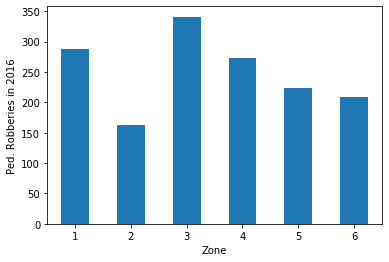

In [42]:
df_cp.loc[(slice(2016,2016), slice(None)), "ROBBERY-PEDESTRIAN"].plot.bar()
plt.xticks(range(6), range(1,7), rotation=0);
plt.xlabel("Zone");
plt.ylabel("Ped. Robberies in 2016");

In [43]:
## In-class exercise:
# What is the average annual number of crimes in each zone (for each type of crime)?
# Hint: use "groupby" with a "level" argument.

In [44]:
df_cp.groupby(by=["Zone"]).mean()

UC2 Literal,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,RAPE,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE
Zone,,,,,,,,,,,
1.0,602.250,748.250,130.625,1054.000,21.500,847.375,944.000,26.375,21.875,332.250,49.625
2.0,135.500,497.750,191.250,546.125,2.625,2015.875,1743.125,16.750,41.750,142.375,20.375
3.0,587.500,938.250,175.125,1063.875,19.000,940.250,919.875,25.125,35.125,340.875,47.625
4.0,477.875,926.625,156.750,1158.000,14.625,1030.125,1186.000,21.750,43.625,315.500,47.250
5.0,206.375,468.750,111.625,146.000,5.500,2353.125,1377.000,19.875,27.000,248.125,13.875
6.0,210.750,681.000,136.250,640.125,8.000,1732.375,1137.750,14.000,36.375,252.750,26.500


In [45]:
df_cp.groupby(level=1).mean()

UC2 Literal,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,RAPE,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE
Zone,,,,,,,,,,,
1.0,602.250,748.250,130.625,1054.000,21.500,847.375,944.000,26.375,21.875,332.250,49.625
2.0,135.500,497.750,191.250,546.125,2.625,2015.875,1743.125,16.750,41.750,142.375,20.375
3.0,587.500,938.250,175.125,1063.875,19.000,940.250,919.875,25.125,35.125,340.875,47.625
4.0,477.875,926.625,156.750,1158.000,14.625,1030.125,1186.000,21.750,43.625,315.500,47.250
5.0,206.375,468.750,111.625,146.000,5.500,2353.125,1377.000,19.875,27.000,248.125,13.875
6.0,210.750,681.000,136.250,640.125,8.000,1732.375,1137.750,14.000,36.375,252.750,26.500


# Seaborn Demo
Seaborn is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics.

https://stanford.edu/~mwaskom/software/seaborn/index.html

Don't forget to include the line
<pre style="color: red; font-weight: bold;">
    %matplotlib inline
</pre>
to direct the output of the plotting functions to the notebook.

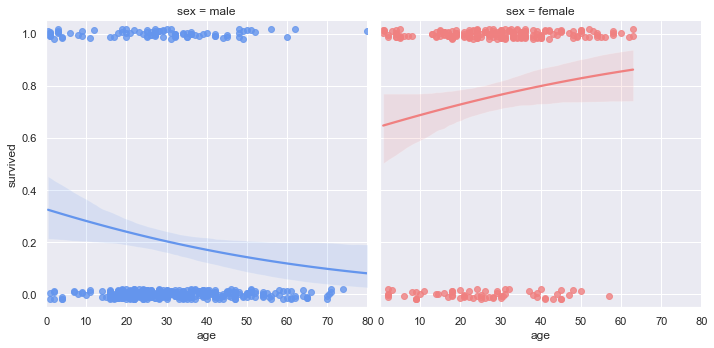

In [46]:
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

# Load the example titanic dataset
df = sns.load_dataset("titanic")

# Make a custom palette with gendered colors
pal = dict(male="#6495ED", female="#F08080")

# Show the survival proability as a function of age and sex
g = sns.lmplot(x="age", y="survived", col="sex", hue="sex", data=df,
               palette=pal, y_jitter=.02, logistic=True)
g.set(xlim=(0, 80), ylim=(-.05, 1.05))

In [47]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
